In [1]:
"""Tutorial for RL introduction, following Chapter 3 of Sutton"""

'Tutorial for RL introduction, following Chapter 3 of Sutton'

# Chapter 3. Reinforcement Learning Problem
In this tutorial we go through the example of computing action-value
function and state-value function following the example given in Chapter 3
of `Reinforcement Learning: An Introduction`.

State value function and action value function for policy $\pi$ are defined
as follow

\begin{align*}
v_{\pi} (s)
  &= \mathbb{E}_{\pi} \lbrack G_t | S_t = s \rbrack \\
q_{\pi}(s, a)
  &= \mathbb{E}_{\pi} \lbrack G_t | S_t = s, A_t = a \rbrack \\
\text{where } & \text{$G_t$ , the sum of the discounted rewards, is} \\
G_t
  &= R_{t+1} + R_{t+2} + R_{t+3} + \dots + R_{T}
\end{align*}

In case of Markov Decision Process, the following can be derived.

\begin{align*}
v_{\pi} (s)
  &= \mathbb{E}_{\pi} \lbrack G_t | S_t = s \rbrack \\
  &= \mathbb{E}_{\pi} \lbrack \sum_{k=0}^{\infty}
     \gamma ^ {k} R_{t+k+1} | S_t = s \rbrack \\
q_{\pi}(s, a)
  &= \mathbb{E}_{\pi} \lbrack G_t | S_t = s, A_t = a \rbrack \\
  &= \mathbb{E}_{\pi} \lbrack \sum_{k=0}^{\infty}
     \gamma ^ {k} R_{t+k+1} | S_t = s, A_t = a \rbrack
\end{align*}

These interweived functions statisfy recursive relationships as follow

\begin{align*}
v_{\pi} (s)
  &= \mathbb{E}_{\pi} \lbrack G_t | S_t = s \rbrack \\
  &= \mathbb{E}_{\pi} \lbrack
     \sum_{k=0}^{\infty} \gamma ^ k R_{t+k+1} | S_t = s \rbrack \\
  &= \mathbb{E}_{\pi} \lbrack
     R_{t+1} + \gamma
     \sum_{k=0}^{\infty} \gamma ^ k R_{t+k+2} | S_t = s \rbrack \\
  &= \sum_a \pi(a|s) \sum_{s'} p(s' |s, a) \lbrack
     r(s, a, s') + \gamma \mathbb{E}_{\pi} \lbrack
         \sum_{k=0}^{\infty} \gamma^{k} R_{t+k+2} | S_{t+1} = s'
       \rbrack
     \rbrack \\
  &= \sum_a \pi(a|s) \sum_{s'} p(s' |s, a) \lbrack
     r(s, a, s') + \gamma v_{\pi}(s')
     \rbrack
\end{align*}

Let us compute and visualize the state-value function through GridWorld
example.
For the detail of the definition, please refer to the Example 3.8
from the book.
- Agent moves in 5 x 5 grid cell
- Agent takes action to move either north, east, west, or south.
- Actions that would move the agent out of grid results in reward of -1
and agent stays where it was before taking the action.
- On success full action, agent moves to new position and receives
0 reward.
- In special state $A$ (0, 1), all action cause the agent to move to $A'$
(4, 1) and reward of 10
- Similarly in $B$ (0, 3), all action cause the agent to move to $B'$
(2, 3) and reward of 5

First, we define `GridWorld` environment as follow

In [2]:
from __future__ import print_function
from __future__ import absolute_import

import numpy as np
import matplotlib.pyplot as plt

import luchador.env
import luchador.agent
from luchador.episode_runner import EpisodeRunner


def _transit(position, action):
    """Transition rule of GridWorld

    Parameters
    ----------
    position : NumPy NDArray
        Coordinate of agent
    action : int
        0, 1, 2, or 3, meaning north, east, west or south respectively

    Returns
    -------
    NumPy NDArray
        New coordinate
    int
        Reward
    """
    reward = 0
    new_position = position.copy()

    if np.all(position == [0, 1]):
        reward = 10
        new_position[:] = [4, 1]
        return new_position, reward
    if np.all(position == [0, 3]):
        reward = 5
        new_position[:] = [2, 3]
        return new_position, reward

    if action == 0:  # North
        move = [-1, 0]
    elif action == 1:  # East
        move = [0, 1]
    elif action == 2:  # West
        move = [0, -1]
    elif action == 3:  # South
        move = [1, 0]

    new_position = new_position + move
    if np.any(new_position < 0) or np.any(new_position > 4):
        reward = -1
        new_position[new_position < 0] = 0
        new_position[new_position > 4] = 4
    return new_position, reward


class GridWorld(luchador.env.BaseEnvironment):
    """GridWorld Example from Sutton, Chapter3."""
    def __init__(self, seed=None):
        self.position = None
        self.rng = np.random.RandomState(seed=seed)

    @property
    def n_actions(self):
        return 4

    def reset(self):
        """Reset position randomly"""
        self.position = self.rng.randint(5, size=2)
        return luchador.env.Outcome(
            reward=0, observation=self.position, terminal=False, state={})

    def step(self, action):
        """Move position based on action and transit rule"""
        self.position, reward = _transit(self.position, action)
        return luchador.env.Outcome(
            reward=reward, observation=self.position, terminal=False, state={})

Then we create agent which
- has equiprobable random policy
- estimates of action-value function via Monte-Calro approach

In [3]:
class GridWorldAgent(luchador.agent.BaseAgent):
    """Agent walk on GridWorld with equiprobable random policy while
    estimating the action values

    Parameters
    ----------
    step_size : float
        StepSize parameter for estimating action value function
    discount : float
        Discount rate for computing state-value function
    initial_q : float
        Initial action value estimation
    """
    def __init__(self, step_size=0.9, discount=0.9, initial_q=10):
        self.step_size = step_size
        self.discount = discount

        self.position = None  # Pre-action position
        self.action_values = initial_q * np.ones((5, 5, 4))

    @property
    def state_values(self):
        """Current estimated state value mapping"""
        return np.mean(self.action_values, axis=2)

    def init(self, _):
        pass

    def reset(self, observation):
        self.position = observation

    def observe(self, action, outcome):
        pos0, pos1 = self.position, outcome.observation

        post_state_value = self.state_values[pos1[0], pos1[1]]
        target = outcome.reward + self.discount * post_state_value

        self.action_values[pos0[0], pos0[1], action] += self.step_size * (
            target - self.action_values[pos0[0], pos0[1], action])
        self.position = pos1

    def act(self):
        return np.random.choice(4)

We run the agent in the environment for setps long enough for action value
estimation to get close enough to theoritical value as given in the book,
Fig.3.5.

State Value:
 [[ 3.30967334  8.78996384  4.42847076  5.32341602  1.49351647]
 [ 1.52230436  2.9931482   2.2510107   1.90857554  0.54846154]
 [ 0.05159643  0.73894369  0.6738938   0.35908764 -0.40224067]
 [-0.97293989 -0.43483119 -0.35409912 -0.58475632 -1.18223195]
 [-1.8570356  -1.34456779 -1.22844634 -1.42197591 -1.97428826]]
Action Value: north
[[ 1.97874029  8.78999857  2.98570892  5.32374653  0.34443688]
 [ 2.97871735  7.91104469  3.9858463   4.79118912  1.34437122]
 [ 1.37017006  2.69398926  2.025935    1.71773175  0.49365051]
 [ 0.04648489  0.66505173  0.60655654  0.32320462 -0.36199383]
 [-0.87559034 -0.39133176 -0.3186462  -0.52616579 -1.06396538]]
Action Value: east
[[ 7.91104314  8.79003639  4.79125101  5.32345466  0.3443786 ]
 [ 2.69385539  2.02616511  1.71773653  0.49370507 -0.50629823]
 [ 0.66528139  0.60655902  0.32322214 -0.36198697 -1.36199142]
 [-0.39129612 -0.31864091 -0.52618199 -1.06395648 -2.06394835]
 [-1.21003207 -1.10559598 -1.27959812 -1.77647742 -2.776729  ]]

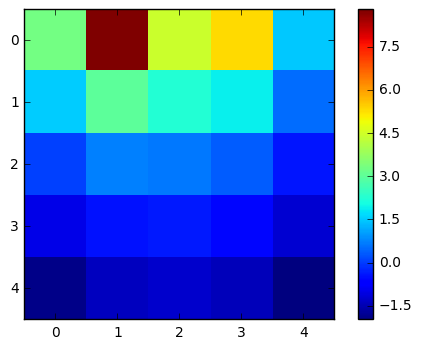

In [4]:
def run_agent(env, agent, episodes=1000, steps=4):
    """Run agent for the given steps and plot the resulting state value"""
    runner = EpisodeRunner(env, agent, max_steps=steps)

    for _ in range(episodes):
        runner.run_episode()

    print('State Value:\n', agent.state_values)
    for i, action in enumerate(['north', 'east', 'west', 'south']):
        print('Action Value:', action)
        print(agent.action_values[:, :, i])

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    img = ax.imshow(agent.state_values, interpolation='nearest', origin='upper')
    fig.colorbar(img)
    plt.show(block=False)


run_agent(
    env=GridWorld(seed=0),
    agent=GridWorldAgent(step_size=0.9, discount=0.9),
    steps=5, episodes=2000,
)

Let's compute the state values for optimal policy. $\pi^{*}$
Computing optimal policy using Monte Carlo (sampling) approach is not
straight forward, as agent has to explore the transitions which are not
optimal.
To overcome this, we take advantage of
- random initialization: All states are visited eventually
- Optimal initial value: All actions are tried eventually

State Value:
 [[ 21.97748529  24.4194281   21.97748529  19.42059442  17.4793048 ]
 [ 19.78031106  21.97748529  19.77973676  17.80176308  16.02182022]
 [ 17.80833068  19.77973676  17.80176308  16.02158677  14.44404944]
 [ 16.07905129  17.80176308  16.02159475  14.42207286  13.32172802]
 [ 15.80785433  16.02158677  14.44216184  13.24213528  12.98410773]]
Action Value: north
[[ 20.14284     24.4194281   20.14284     19.41960225  17.4299844 ]
 [ 19.78031106  21.97748529  19.77973676  17.71821741  15.79872796]
 [ 17.80833068  19.77973676  17.80176308  16.02158677  14.44404944]
 [ 16.07905129  17.80176308  16.02159475  14.42207286  13.15695668]
 [ 15.80785433  16.02158677  14.42540686  13.16183947  12.42438455]]
Action Value: east
[[ 21.97748529  24.4194281   21.44322536  19.42059442  17.4299844 ]
 [ 19.77991772  21.77889777  16.66548619  17.69478021  14.9612858 ]
 [ 17.80286043  18.40741142  14.80358256  15.14358728  12.71477008]
 [ 16.03692167  16.79880164  14.66865412  13.05200127  12.714

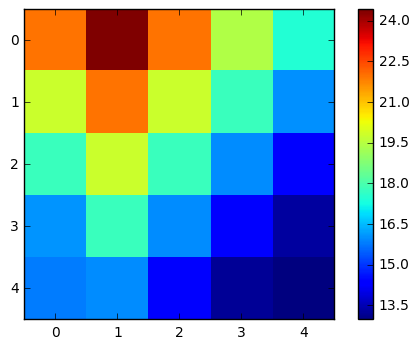

In [5]:
class GreedyGridWorldAgent(GridWorldAgent):
    """Agent act on greedy policy"""
    def __init__(self, step_size=0.9, discount=0.9, initial_q=30):
        super(GreedyGridWorldAgent, self).__init__(
            step_size=step_size, discount=discount, initial_q=initial_q)

    @property
    def state_values(self):
        return np.max(self.action_values, axis=2)

    def act(self):
        return np.argmax(
            self.action_values[self.position[0], self.position[1]])


run_agent(
    env=GridWorld(seed=0),
    agent=GreedyGridWorldAgent(step_size=0.9, discount=0.9, initial_q=30),
    steps=100, episodes=100,
)